# Benchmarking: Proximal Gradient Method vs. Coordinate Descent

In this notebook, we compare the CPU runtimes of two implementations of ElasticNet: 

| Package name | Optimisation algorithm | Abbreviation |
| --- | --- | --- |
| sklearn  | coordinate descent | `sk` |
| prox_elasticnet  | (accelerated) proximal gradient method | `px` |

Below, we import the necessary packages.

In [1]:
import time
import numpy as np
import copy
from sklearn.linear_model import ElasticNet as ElasticNet_sk
from prox_elasticnet import ElasticNet as ElasticNet_px
from sklearn.linear_model import ElasticNetCV as ElasticNetCV_sk
from prox_elasticnet import ElasticNetCV as ElasticNetCV_px
np.random.seed(319159)

from sklearn import __version__ as sklearn_version
print("Using sklearn version {}.".format(sklearn_version))

Using sklearn version 0.17.1.


We initialise the `ElasticNet` and `ElasticNetCV` objects for each implementation using the default parameters. This means `alpha = 1` and `l1_ratio = 0.5`, i.e. the regularisation term is:
\begin{equation}
    \frac{1}{2} \| w \|_1 + \frac{1}{2} \|w\|_2^2
\end{equation}

In [2]:
e_sk = ElasticNet_sk(max_iter = 50000)
e_px = ElasticNet_px(max_iter = 50000)
ecv_sk = ElasticNetCV_sk(max_iter = 50000)
ecv_px = ElasticNetCV_px(max_iter = 50000)

## Dataset

We generate artificial datasets following the procedure outlined in:
> T. Hastie, R. Tibshirani, and  M. Wainwright, *Statistical Learning with Sparsity: The Lasso and Generalizations*. CRC Press, 2015. pp. 117-118

This involves:
1. Generating a $n \times k$ feature matrix $X$ with normally distributed entries and pairwise correlation $\rho$ between the features.
2. Generating a weight vector $w$ such that the $i$-th component follows the rule: $w_i = (-1)^i \exp\left(-\frac{\pi}{40}(i - 1)^2\right)$.
3. Generating a label vector $y$ according to the rule: $y_i = \sum_{j = 1}^{k} x_{ij} w_j + \sigma \varepsilon_i$ where $\varepsilon_i \sim N(0, 1)$ and $\operatorname{var}[y_i]/\sigma^2 = 9$.

In [3]:
def generate_data(n, k, rho):
    t_start = time.time()
    mean = np.zeros(k)
    cov = np.empty((k,k))
    cov.fill(rho)
    np.fill_diagonal(cov, 1)
    X = np.random.multivariate_normal(mean, cov, n)
    w = np.fromfunction(lambda i: (-1)**i * np.exp(- np.pi/40.0 * (i - 1)**2), (k,), dtype=float)
    Xw = np.dot(X,w)
    epsilon = np.random.normal(0, 1, n)
    sigma = np.sqrt(np.dot(w,w))/(2*np.sqrt(2))
    y = Xw + sigma * epsilon
    t_end = time.time()
    print("Generated data in {:.4f} s\n".format(t_end - t_start))
    return X, y

The plot below demonstrates that the weight vectors generated by this formula are very sparse.

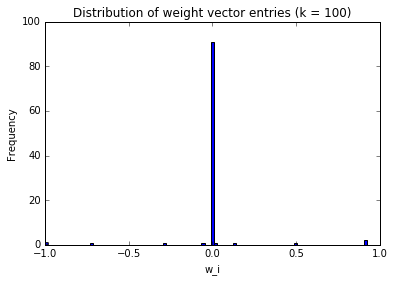

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(np.fromfunction(lambda i: (-1)**i * np.exp(- np.pi/40.0 * (i - 1)**2), (100,), dtype=float), bins=101)
plt.xlabel("w_i")
plt.ylabel("Frequency")
plt.title("Distribution of weight vector entries (k = 100)")
plt.show()

## Simulations

We will run 4 simulations. The first two will be in the regime $n \gg k$ and the last two will be in the regime $k \gg n$. Having a large pairwise correlation (`rho`) between the features makes fitting the model more challenging.

| index | n | k | rho |
| --- | --- | --- | --- |
| 1 | 10000 | 100 | 0 |
| 2 | 10000 | 100 | 0.5 |
| 3 | 100 | 10000 | 0 |
| 4 | 100 | 10000 | 0.5 |

We define a function below which repeats the fitting multiple times and estimates the mean CPU time and standard error in the estimate.

In [5]:
def repeat_and_time(enet_obj, X, y, n_repeats):
    enet = copy.deepcopy(enet_obj)
    t = np.empty(n_repeats, dtype = float)
    for i in range(n_repeats):
        t_start = time.process_time()
        enet.fit(X,y)
        t_end = time.process_time()
        t[i] = t_end - t_start
    t_avg = np.mean(t)
    t_stderr = np.std(t) / np.sqrt(n_repeats)
    if hasattr(enet, 'eta'):
        obj_str = "px"
    else:
        obj_str = "sk"
    print("Method: {}".format(obj_str))
    print("----------")
    print("Repeated fit method {} times.".format(n_repeats))
    print("Average time: {:.4f} s \t Standard error: {:.4f} s\n".format(t_avg, t_stderr))
    return enet, t_avg, t_stderr

In [6]:
n_repeat = 40
X_1, y_1 = generate_data(n = 10000, k = 100, rho = 0)
ecv_sk_1, t_avg_sk_1, t_se_px_1 = repeat_and_time(ecv_sk, X_1, y_1, n_repeat)
ecv_px_1, t_avg_px_1, t_se_px_1 = repeat_and_time(ecv_px, X_1, y_1, n_repeat)

Generated data in 0.1109 s

Method: sk
----------
Repeated fit method 40 times.
Average time: 0.2474 s 	 Standard error: 0.0014 s

Method: px
----------
Repeated fit method 40 times.
Average time: 0.3007 s 	 Standard error: 0.0018 s



In [7]:
X_2, y_2 = generate_data(n = 10000, k = 100, rho = 0.5)
ecv_sk_2, t_avg_sk_2, t_se_sk_2 = repeat_and_time(ecv_sk, X_2, y_2, n_repeat)
ecv_px_2, t_avg_px_2, t_se_px_2 = repeat_and_time(ecv_px, X_2, y_2, n_repeat)

Generated data in 0.0976 s

Method: sk
----------
Repeated fit method 40 times.
Average time: 0.4403 s 	 Standard error: 0.0026 s

Method: px
----------
Repeated fit method 40 times.
Average time: 1.4455 s 	 Standard error: 0.0103 s



In [8]:
X_3, y_3 = generate_data(n = 100, k = 10000, rho = 0)
ecv_sk_3, t_avg_sk_3, t_se_sk_3 = repeat_and_time(ecv_sk, X_3, y_3, n_repeat)
ecv_px_3, t_avg_px_3, t_se_px_3 = repeat_and_time(ecv_px, X_3, y_3, n_repeat)

Generated data in 1068.7449 s

Method: sk
----------
Repeated fit method 40 times.
Average time: 4.6807 s 	 Standard error: 0.0141 s

Method: px
----------
Repeated fit method 40 times.
Average time: 13.6731 s 	 Standard error: 0.0428 s



In [9]:
X_4, y_4 = generate_data(n = 100, k = 10000, rho = 0.5)
ecv_sk_4, t_avg_sk_4, t_se_sk_4 = repeat_and_time(ecv_sk, X_4, y_4, n_repeat)
ecv_px_4, t_avg_px_4, t_se_px_4 = repeat_and_time(ecv_px, X_4, y_4, n_repeat)

Generated data in 1060.7540 s

Method: sk
----------
Repeated fit method 40 times.
Average time: 31.1145 s 	 Standard error: 0.0329 s

Method: px
----------
Repeated fit method 40 times.
Average time: 82.4542 s 	 Standard error: 0.4635 s



On these datasets, coordinate descent runs between 1 - 3 times faster than the accelerated proximal gradient method. This is to be expected since the weight vector is very sparse (as demonstrated above), and coordinate descent can take advantage of this sparsity.

## Dataset 2

We will now construct a dataset with more dense weight vectors using the rule
\begin{equation}
    w_i = 10 \cdot (-1)^{i} \sqrt{\sin\left(\frac{\pi i}{20} \right) \frac{i}{k}}.
\end{equation}
This produces a weight vector for which 5% of the entries are zero. The distribution of the entries is plotted below.

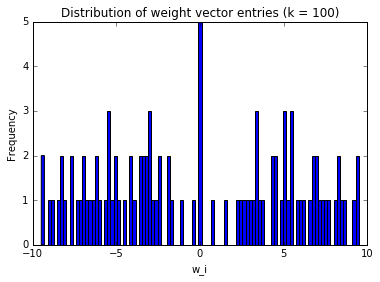

In [11]:
plt.hist(10*np.fromfunction(lambda i: (-1)**i * np.sqrt(np.abs(np.sin(np.pi * i/20)) * i/100), (100,), dtype=float), bins=101)
plt.xlabel("w_i")
plt.ylabel("Frequency")
plt.title("Distribution of weight vector entries (k = 100)")
plt.show()

We redefine the `generate_data` function to use the more dense weight vector rule.

In [10]:
def generate_data(n, k, rho):
    t_start = time.time()
    mean = np.zeros(k)
    cov = np.empty((k,k))
    cov.fill(rho)
    np.fill_diagonal(cov, 1)
    X = np.random.multivariate_normal(mean, cov, n)
    w = np.fromfunction(lambda i: 10 * (-1)**i * np.sqrt(np.abs(np.sin(np.pi * i/20)) * i/k), (k,), dtype=float)
    Xw = np.dot(X,w)
    epsilon = np.random.normal(0, 1, n)
    sigma = np.sqrt(np.dot(w,w))/(2*np.sqrt(2))
    y = Xw + sigma * epsilon
    t_end = time.time()
    print("Generated data in {:.4f} s\n".format(t_end - t_start))
    return X, y

Below we repeat all of the experiments using the new dataset.

In [12]:
n_repeat = 10
X_1, y_1 = generate_data(n = 10000, k = 100, rho = 0)
ecv_sk_1, t_avg_sk_1, t_se_px_1 = repeat_and_time(ecv_sk, X_1, y_1, n_repeat)
ecv_px_1, t_avg_px_1, t_se_px_1 = repeat_and_time(ecv_px, X_1, y_1, n_repeat)

Generated data in 0.0933 s

Method: sk
----------
Repeated fit method 10 times.
Average time: 0.2575 s 	 Standard error: 0.0018 s

Method: px
----------
Repeated fit method 10 times.
Average time: 0.3100 s 	 Standard error: 0.0022 s



In [13]:
X_2, y_2 = generate_data(n = 10000, k = 100, rho = 0.5)
ecv_sk_2, t_avg_sk_2, t_se_sk_2 = repeat_and_time(ecv_sk, X_2, y_2, n_repeat)
ecv_px_2, t_avg_px_2, t_se_px_2 = repeat_and_time(ecv_px, X_2, y_2, n_repeat)

Generated data in 0.0950 s

Method: sk
----------
Repeated fit method 10 times.
Average time: 4.0721 s 	 Standard error: 0.0376 s

Method: px
----------
Repeated fit method 10 times.
Average time: 1.9893 s 	 Standard error: 0.0250 s



In [14]:
X_3, y_3 = generate_data(n = 100, k = 10000, rho = 0)
ecv_sk_3, t_avg_sk_3, t_se_sk_3 = repeat_and_time(ecv_sk, X_3, y_3, n_repeat)
ecv_px_3, t_avg_px_3, t_se_px_3 = repeat_and_time(ecv_px, X_3, y_3, n_repeat)

Generated data in 1070.9330 s

Method: sk
----------
Repeated fit method 10 times.
Average time: 18.6931 s 	 Standard error: 0.0276 s

Method: px
----------
Repeated fit method 10 times.
Average time: 7.3416 s 	 Standard error: 0.0673 s



In [15]:
X_4, y_4 = generate_data(n = 100, k = 10000, rho = 0.5)
ecv_sk_4, t_avg_sk_4, t_se_sk_4 = repeat_and_time(ecv_sk, X_4, y_4, n_repeat)
ecv_px_4, t_avg_px_4, t_se_px_4 = repeat_and_time(ecv_px, X_4, y_4, n_repeat)

Generated data in 1063.8242 s



/usr/lib64/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/lib64/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/lib64/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/lib64/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/lib64/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteratio

Method: sk
----------
Repeated fit method 10 times.
Average time: 97.7128 s 	 Standard error: 0.1332 s

Method: px
----------
Repeated fit method 10 times.
Average time: 24.4031 s 	 Standard error: 0.0131 s



Now we see that the proximal gradient method generally has the performance advantage over coordinate descent. It performs between 2 - 4 times faster on three of these datasets.